In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import seaborn as sns
import folium
import folium.plugins as plugins
from sklearn.cluster import KMeans

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


# Data Preparation
## Trip Duration Clean-up
Deal with **outliers** associated with the `trip_duration` variable  
Exclude data that lies outside 2 standard deviations from the mean. 

In [6]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

## Check latitude/longitude bounds
Latitude: -85 to +85, Longitude: -180 to +180

In [7]:
print('Latitude bounds: {} to {}'.format(
    max(train.pickup_latitude.min(), train.dropoff_latitude.min()),
    max(train.pickup_latitude.max(), train.dropoff_latitude.max())
))

Latitude bounds: 34.359695434570305 to 51.88108444213867


In [8]:
print('Longitude bounds: {} to {}'.format(
    max(train.pickup_longitude.min(), train.dropoff_longitude.min()),
    max(train.pickup_longitude.max(), train.dropoff_longitude.max())
))

Longitude bounds: -121.9333038330078 to -61.33552932739258


## Latitude and Longitude Clean-up

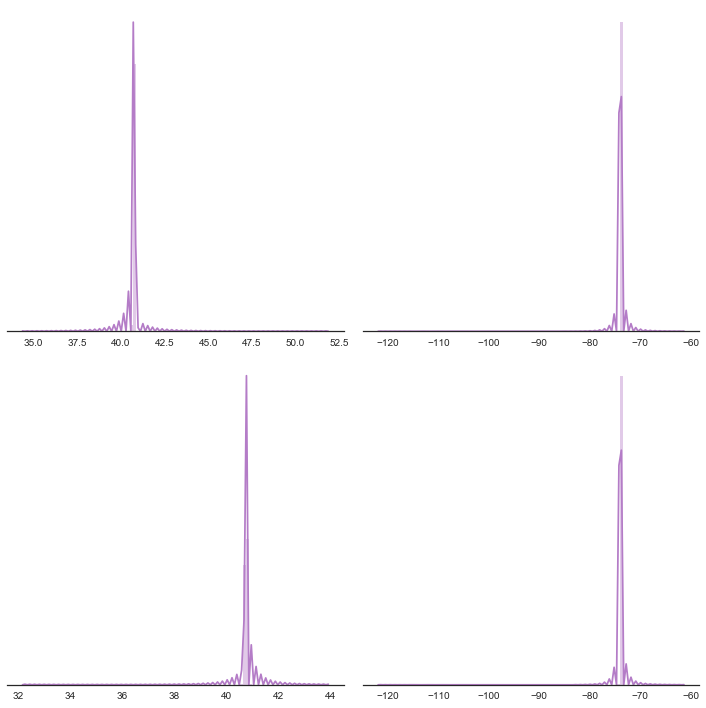

In [13]:
start = time.time()
# seaborn sns
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
plt.show()

In [14]:
allLat  = np.array(list(train['pickup_latitude'])  + list(train['dropoff_latitude']))
allLong = np.array(list(train['pickup_longitude']) + list(train['dropoff_longitude']))

# longitude and latitude limits
longLimits = [np.percentile(allLong, 0.5), np.percentile(allLong, 99.5)]
latLimits  = [np.percentile(allLat , 0.5), np.percentile(allLat , 99.5)]

In [15]:
city_long_x=longLimits[0]
city_long_y=longLimits[1]
city_lat_x =latLimits[0]
city_lat_y=latLimits[1]

# clean-up
train = train[train['pickup_longitude'] <= city_long_y]
train = train[train['pickup_longitude'] >= city_long_x]
train = train[train['pickup_latitude'] <= city_lat_y]
train = train[train['pickup_latitude'] >= city_lat_x]
train = train[train['dropoff_longitude'] <= city_long_y]
train = train[train['dropoff_longitude'] >= city_long_x]
train = train[train['dropoff_latitude'] <= city_lat_y]
train = train[train['dropoff_latitude'] >= city_lat_x]

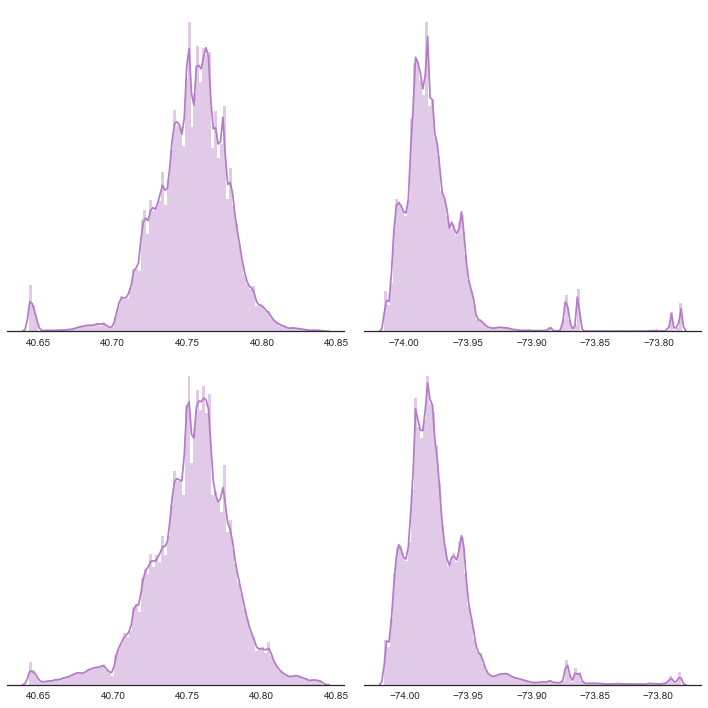

In [16]:
start = time.time()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(train['pickup_latitude'].values, label = 'pickup_latitude',color="m",bins = 100, ax=axes[0,0])
sns.distplot(train['pickup_longitude'].values, label = 'pickup_longitude',color="m",bins =100, ax=axes[0,1])
sns.distplot(train['dropoff_latitude'].values, label = 'dropoff_latitude',color="m",bins =100, ax=axes[1, 0])
sns.distplot(train['dropoff_longitude'].values, label = 'dropoff_longitude',color="m",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()
end = time.time()
plt.show()

## Check Missing Values 
check whether we have data missing in the train and the test set.

In [17]:
print(train.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [18]:
print(test.isnull().sum())

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


**Good! no N/A values**

## Check for duplicate ids

In [19]:
print('No of Duplicates, Trip IDs: {}'.format(len(train) - len(train.drop_duplicates(subset='id'))))

No of Duplicates, Trip IDs: 0


## Check Number of Passengers
The common sense implies values between 1 and 10, we should check 0

In [20]:
print('Passengers: {} to {}'.format(train.passenger_count.min(), train.passenger_count.max()))

Passengers: 0 to 6


## Passenger_Count Clean-up

let's also drop trips with passenger count = 0

In [30]:
print('Empty trips: {}'.format(train[train.passenger_count == 0].shape[0]))
train = train[train.passenger_count > 0]
print('Dropped trips with no passengers')

Empty trips: 0
Dropped trips with no passengers


In [22]:
# Consistency check (check to see whether dropoff_time - pickup_time = duration)
# distributions of pickup_datetime and dropoff_datetime
# Add histogram of trip duration, x-axis is trip duration time (in min), y-axis is counts
# Add histogram of trip duration to show how to remove extre data
# Add histogram of different vendor-id, x-axis:Day (monday, tuesday, etc), y-axis: total count of pick-ups
# Add histogram of different vendor-id, x-axis:hour, y-axis: total count of pick-ups
# Add histogram of Pickup date/time vs trip_duration
# WeekDay Trip Distribution for different hours of the day
# WeekEnd Trip Distribution for different hours of the day

# Weekly Trip Distribution for different days of the week
# Yearly Trip Distribution for different days of the year


In [23]:
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['dropoff_hour'] = pd.DatetimeIndex(train['dropoff_datetime']).hour
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['pickup_hour'] = pd.DatetimeIndex(train['pickup_datetime']).hour
total_rows = len(train.index)

In [31]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dropoff_hour,pickup_hour,day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,12,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,13,5


# Heat Map

In [33]:
heat_df =train.sample(n=10000)

#Extract required columns
heat_df = heat_df[['dropoff_latitude', 'dropoff_longitude','dropoff_hour', 'pickup_latitude', 'pickup_longitude','pickup_hour']]


# Ensure you're handing it floats
heat_df['dropoff_latitude'] = heat_df['dropoff_latitude'].astype(float)
heat_df['dropoff_longitude'] = heat_df['dropoff_longitude'].astype(float)
heat_df['pickup_latitude'] = heat_df['pickup_latitude'].astype(float)
heat_df['pickup_longitude'] = heat_df['pickup_longitude'].astype(float)

#remove NANs
heat_df = heat_df.dropna(axis=0)


# Create weight column, using date
#heat_df['Weight'] = heat_df['dropoff_hour']
heat_df['dropoff_hour'] = heat_df['dropoff_hour'].astype(float)
heat_df['pickup_hour'] = heat_df['pickup_hour'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['dropoff_latitude','dropoff_longitude', 'dropoff_hour','pickup_latitude','pickup_longitude', 'pickup_hour'])

In [26]:
# Display the map based on the pickup location within the time range of (0,24)
# Use Folium to generate heatmap
heat_data_pickup = [[[row['pickup_latitude'],row['pickup_longitude']] 
                for index, row in heat_df[heat_df['pickup_hour'] == i].iterrows()] 
                 for i in range(0,24)]
newyork_on_heatmap_1 = folium.Map(location=[40.767937,-73.982155 ],tiles= "Stamen Terrain",
                    zoom_start = 13)
hm = plugins.HeatMapWithTime(heat_data_pickup,auto_play=True,max_opacity=0.8)
hm.add_to(newyork_on_heatmap_1)

newyork_on_heatmap_1

In [34]:
# Display the map based on the dropoff location within the time range of (0,24)
newyork_on_heatmap = folium.Map(location=[40.767937,-73.982155 ],tiles= "Stamen Terrain",
                    zoom_start = 13) 

# List comprehension to make out list of lists
heat_data = [[[row['dropoff_latitude'],row['dropoff_longitude']] 
                for index, row in heat_df[heat_df['dropoff_hour'] == i].iterrows()] 
                 for i in range(0,24)]

# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data,auto_play=True,max_opacity=0.8)
hm.add_to(newyork_on_heatmap)

newyork_on_heatmap

In [27]:
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek

/Users/ambassador/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


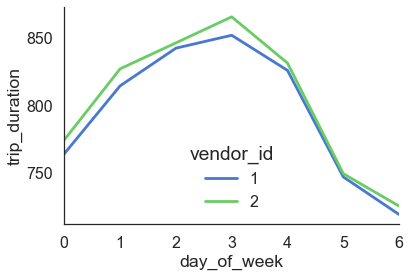

In [28]:
summary_wdays_avg_duration = pd.DataFrame(train.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)

# Spatial density plot of the pickup and dropoff locations

In [38]:
#%% plot scatter of trip duration vs. aerial distance between pickup and dropoff
train['log duration']       = np.log1p(train['duration [min]'])
train['euclidian distance'] = np.sqrt((train['src lat [km]']  - train['dst lat [km]'] )**2 + 
                                       (train['src long [km]'] - train['dst long [km]'])**2)

fig, axArray = plt.subplots(nrows=1,ncols=2,figsize=(13,6))
axArray[0].scatter(train['euclidian distance'], train['duration [min]'],c='r',s=5,alpha=0.01); 
axArray[0].set_xlabel('Aerial Euclidian Distance [km]'); axArray[0].set_ylabel('Duration [min]')
axArray[0].set_xlim(train['euclidian distance'].min(),train['euclidian distance'].max())
axArray[0].set_ylim(train['duration [min]'].min(),train['duration [min]'].max())
axArray[0].set_title('trip Duration vs Aerial trip Distance')

axArray[1].scatter(train['euclidian distance'], train['log duration'],c='r',s=5,alpha=0.01); 
axArray[1].set_xlabel('Aerial Euclidian Distance [km]'); axArray[1].set_ylabel('log(1+Duration) [log(min)]')
axArray[1].set_xlim(train['euclidian distance'].min(),train['euclidian distance'].max())
axArray[1].set_ylim(train['log duration'].min(),train['log duration'].max())
axArray[1].set_title('log of trip Duration vs Aerial trip Distance')

KeyError: 'duration [min]'

In [37]:
# show the log density of pickup and dropoff locations
imageSize = (700,700)
longRange = [-5,19]
latRange = [-13,11]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds =                (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds,allLongInds):
    locationDensityImage[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log(locationDensityImage+1),cmap='hot')
ax.set_axis_off()

IndexError: index -868 is out of bounds for axis 0 with size 700